In [2]:
import os
from glob import glob
import tensorflow as tf
import pickle
import numpy as np
from ImageDataGenerator import ImageDataGenerator
import cv2
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
files_x = [file for file in glob("sample_dataset/image/*.png")]
files_test = [file for file in glob("sample_dataset/*.png")]
files_y = [file for file in glob("sample_dataset/mask/*.png")]

In [40]:
def load_image(file):
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    return image

def load_mask(file):
    mask = mpimg.imread(file)
    mask = cv2.resize(mask, (224, 224))
    return mask

def load_all_image_files(files): 
    images = [load_image(file) for file in files]
    images = np.stack(images)
    images = np.array(images)
    return images

def load_all_mask_files(files):
    masks = [load_mask(file) for file in files]
    masks = np.stack(masks)
    masks = masks[:, :, :, 3:4]
#     masks = np.array(masks)
    return masks

images = load_all_image_files(files_x)

masks = load_all_mask_files(files_y)

tests = load_all_image_files(files_test)

# only do 1 image for now
# images = images[0:1]
# masks = masks[0:1]

print(images.shape, masks.shape)

(18, 224, 224, 3) (18, 224, 224, 1)


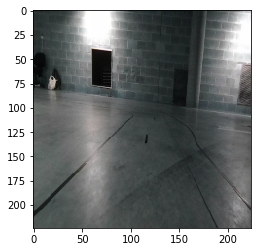

In [5]:
plt.imshow(images[0])


(224, 224)


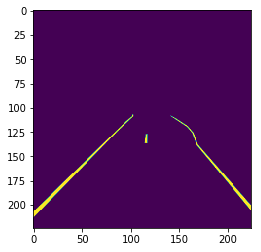

In [6]:
mask = np.squeeze(masks[0], axis=2)
print(mask.shape)
plt.imshow(mask)

In [7]:
import threading
class BatchIndices(object):
    def __init__(self, n, batch_size, shuffle=False):
        self.n, self.batch_size, self.shuffle = n, batch_size, shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.batch_size, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [8]:
bi = BatchIndices(10,3)
[next(bi) for o in range(5)]

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8]),
 array([9]),
 array([0, 1, 2])]

In [9]:
bi = BatchIndices(10,3,True)
[next(bi) for o in range(5)]

[array([3, 7, 2]),
 array([0, 5, 9]),
 array([8, 6, 1]),
 array([4]),
 array([5, 2, 3])]

In [10]:
class segm_generator(object):
    def __init__(self, x, y, batch_size=64, out_sz=(224,224), train=True):
        self.x, self.y, self.batch_size, self.train = x, y, batch_size, train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, batch_size, train)
        self.ro, self.co = out_sz
#         self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)
    
    def get_item(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

    def get_item2(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys)

In [11]:
def overlay_mask(img, mask):
    overlay = np.copy(mask)
    overlay[overlay>=0.9] = 255
    overlay[overlay<0.9] = 0
    overlay = overlay.astype(np.uint8)
    overlay = cv2.merge((np.zeros_like(overlay), overlay, np.zeros_like(overlay)))
    combined = cv2.addWeighted(img, 1, overlay, 0.5, 0)
    return combined

def plot_images(img, mask):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    combined = overlay_mask(img, mask)
    plt.imshow(combined)

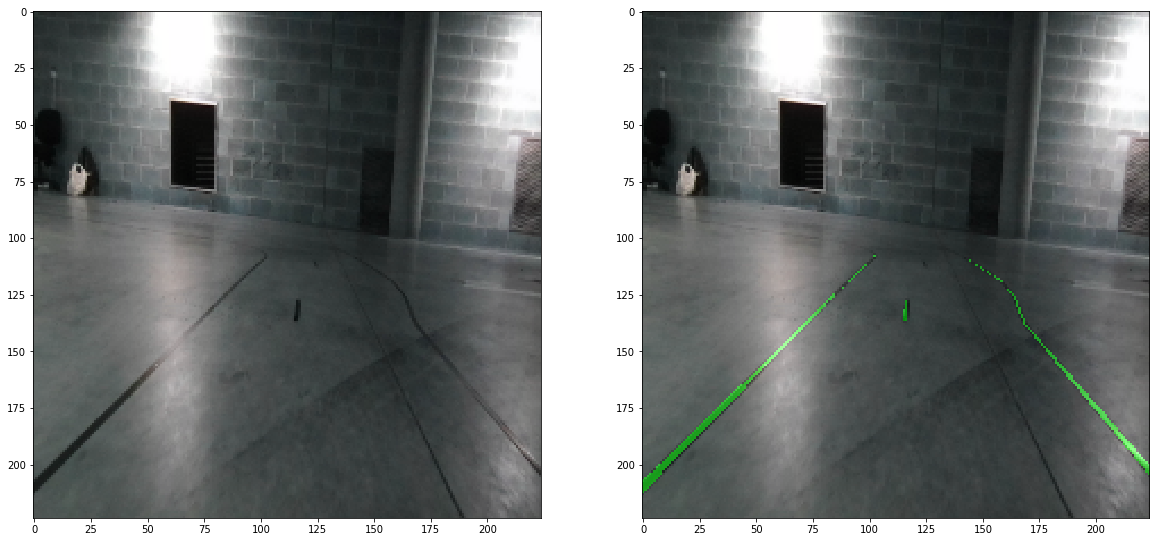

In [12]:
gen = segm_generator(images, masks, 8, train=False)
x, y = next(gen)

plot_images(x[0], y[0])


https://github.com/0bserver07/One-Hundred-Layers-Tiramisu/blob/master/model-tiramasu-56.py

In [13]:
# import keras.models as models
from keras.models import Model
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.layers import Input, Conv2D, Conv2DTranspose

from keras import backend as K

import cv2
import numpy as np
import json

# weight_decay = 0.0001
from keras.regularizers import l2


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = y_pred + threshold_shift

    tp = K.sum(y_true * y_pred_bin) + K.epsilon()
    fp = K.sum(K.clip(y_pred_bin - y_true, 0, 1))
    fn = K.sum(K.clip(y_true - y_pred, 0, 1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

def fbeta_loss(y_true, y_pred):
    return -fbeta(y_true, y_pred)

class Tiramisu():
    def __init__(self, load=False):
        if load:
            self.load()
        else:
            self.create()
        
    def DenseBlock(self, x, nb_layers, filters, name="dense_block"):
        layers = [x]
        for i in range(nb_layers):
            x = BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001))(x)
            x = Activation('relu')(x)
            x = Conv2D(filters, kernel_size=(3, 3), padding='same', 
                       name=name+"_conv_layer_"+str(i), kernel_initializer="he_uniform")(x)
            x = Dropout(0.2)(x)
            layers.append(x)
            x = Concatenate(name=name+"_concatenate_"+str(i))(layers)
#             filters += growth_rate
        return x

    def TransitionDown(self, x, filters, name="transition_down"):
        x = BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001))(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size=(1, 1), padding='same', 
                   name=name+"_conv", kernel_initializer="he_uniform")(x)
        x = Dropout(0.2)(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name=name+"_pool")(x)
        return x

    def TransitionUp(self, x, filters, skip_connection, name="transition_up"):
        x = Conv2DTranspose(100,  kernel_size=(3, 3), strides=(2, 2), padding='same', 
                            name=name+"_conv", kernel_initializer="he_uniform")(x)
        x = Concatenate(name=name+"_concatenate")([x, skip_connection])
        return x


    def create(self):
        model_input = Input(shape=(224,224,3))
        first_layer = Conv2D(12, kernel_size=(3, 3), padding='same',
                            kernel_initializer="he_uniform",
                            kernel_regularizer = l2(0.0001), name="first_layer")(model_input)

        nb_layers = 2
        nb_filters = 12
        growth_rate = 12
        # total_filters = input + nb_layers*nb_filters
        
        filters_1 = 12 + nb_layers * nb_filters  # 12 + 2 * 12 = 36
        block_1 = self.DenseBlock(first_layer, nb_layers, nb_filters, name="block1")
        down = self.TransitionDown(block_1, filters_1, name="block1_TD")

        filters_2 = filters_1 + nb_layers * nb_filters # 36 + 2 * 12 = 60
        block_2 = self.DenseBlock(down, nb_layers, nb_filters, name="block2")
        down = self.TransitionDown(block_2, filters_2, name="block2_TD")
        
        filters_3 = filters_2 + nb_layers * nb_filters # 60 + 2 * 12 = 84
        block_3 = self.DenseBlock(down, nb_layers, nb_filters, name="block3")
        down = self.TransitionDown(block_3, filters_3, name="block3_TD")
        
        filters_4 = filters_3 + nb_layers * nb_filters # 84 + 2 * 12 = 108   
        block_4 = self.DenseBlock(down, nb_layers, nb_filters, name="block4")
        
        up = self.TransitionUp(block_4, filters_4, block_3, name="TU") # 108 + 84  = 192
        
        filters_up_1 = filters_4 + filters_3 + nb_layers * nb_filters # 192 + 2 * 12 = 216
        block_3 = self.DenseBlock(up, nb_layers, nb_filters, name="block3_up")  
        up = self.TransitionUp(block_3, filters_up_1, block_2, name="block3_TU")
        
        filters_up_2 = filters_up_1 + filters_2 + nb_layers * nb_filters # 216 + 60 + 2 * 12  = 300
        block_2 = self.DenseBlock(up, nb_layers, nb_filters, name="block2_up")
        up = self.TransitionUp(block_2, filters_up_2, block_1, name="block2_TU")
        
        filters_up_1 = filters_up_2 + filters_1 + nb_layers * nb_filters # 300 + 36 + 2 * 12 = 360
        block_1 = self.DenseBlock(up, nb_layers, nb_filters, name="block1_up")
        
        
        last_layer = Conv2D(1, kernel_size=(3, 3), padding='same',
                            kernel_initializer="he_uniform",
                            kernel_regularizer = l2(0.0001), name="last_layer")(block_1)
        out = Activation('sigmoid')(last_layer)
        
        self.model = Model(inputs=[model_input], outputs=[out])
        self.model.summary()

#         with open('tiramisu_fc_dense56_model.json', 'w') as outfile:
#             outfile.write(json.dumps(json.loads(model.to_json()), indent=3))

    def save(self):
#         self.model.save("tiramisu_model.h5", overwrite=True)
        self.model.save_weights("tiramisu_weights.h5", overwrite=True)
        
    def load(self):
        self.create()
        self.model.load_weights("tiramisu_weights.h5")
        
    def predict(self, images):
        return self.model.predict(images)

    def predict_one(self, image):
        return self.model.predict(np.expand_dims(image, axis=0))[0]

tiramisu = Tiramisu(load=True)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
first_layer (Conv2D)             (None, 224, 224, 12)  336         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 224, 224, 12)  896         first_layer[0][0]                
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 224, 224, 12)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [15]:
# tiramisu.model.compile(loss="binary_crossentropy", 
#               optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])
tiramisu.model.compile(loss=dice_coef_loss, 
              optimizer=keras.optimizers.Adam(1e-3), metrics=[fbeta])

In [14]:
tiramisu.model.optimizer=keras.optimizers.Adam(1e-3)
history = tiramisu.model.fit_generator(gen, steps_per_epoch=1, epochs=2, verbose=2)

Epoch 1/2
3s - loss: -7.4240e-01 - fbeta: 0.7647
Epoch 2/2
0s - loss: -7.5313e-01 - fbeta: 0.8258


(1, 224, 224, 3)
CPU times: user 768 ms, sys: 140 ms, total: 908 ms
Wall time: 924 ms


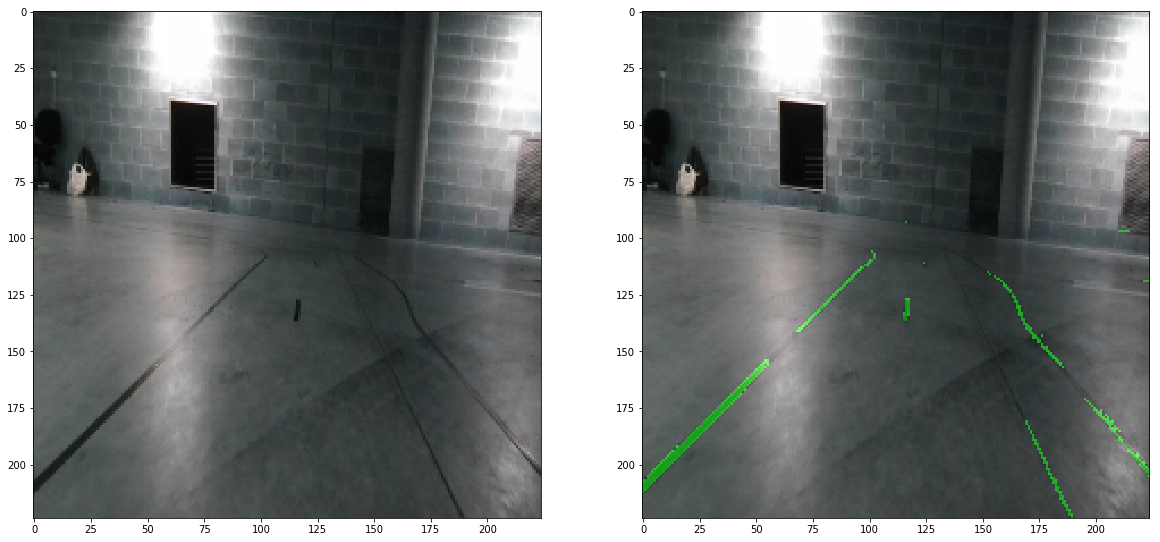

In [16]:
test = x[0:1]
print(test.shape)

%time test_label = tiramisu.model.predict(test)
# print(test_label)
plot_images(test[0], test_label[0])

out = np.squeeze(test_label[0])
# plt.imshow(out)
# print(out)

(18, 224, 224, 3)
CPU times: user 12 ms, sys: 16 ms, total: 28 ms
Wall time: 28 ms


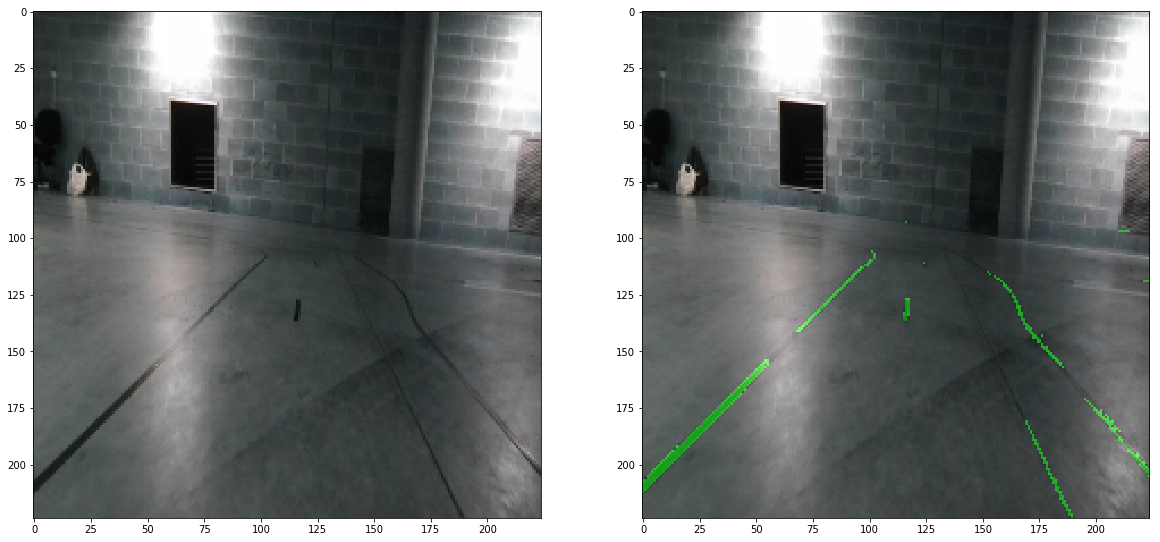

In [41]:
index=np.random.randint(tests.shape[0])
test = tests[index:index+1]
test = images
print(test.shape)

# %time test_label = tiramisu.model.predict(test)
%time test_label = tiramisu.predict_one(test[0])
# print(test_label)
# plot_images(test[0], test_label[0])
plot_images(test[0], test_label)

out = np.squeeze(test_label[0])
# plt.imshow(out)
# print(out)

In [21]:
from moviepy.editor import ImageSequenceClip



In [22]:

def to_clip(images, filename="movie.mp4"):
    images_out = []
    for i in range(images.shape[0]):
        images_out.append(images[i])
    clip = ImageSequenceClip(images_out, fps=30)
    clip.write_videofile(filename,fps=30)
    
to_clip(tests)

[MoviePy] >>>> Building video movie.mp4
[MoviePy] Writing video movie.mp4


 99%|█████████▉| 82/83 [00:00<00:00, 785.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie.mp4 



In [23]:
files_race1 = [file for file in glob("race1/*.jpg")]

images_race1 = load_all_image_files(files_race1)

print(images_race1.shape)

(2612, 224, 224, 3)


In [29]:
images_race1_test = images_race1[0:200]
print(images_race1_test.shape)

(200, 224, 224, 3)


In [31]:
images_race1_predictions=[]
for idx, img in enumerate(images_race1):
    img = np.expand_dims(img, axis=0)
    output = tiramisu.model.predict(img)
    output = overlay_mask(img[0], output[0])
    images_race1_predictions.append(output)
images_race1_predictions = np.stack(images_race1_predictions)

# %time predictions = tiramisu.model.predict(images_race1_test)

# print(predictions.shape)
to_clip(images_race1_predictions)

CPU times: user 40 ms, sys: 16 ms, total: 56 ms
Wall time: 33.7 ms
CPU times: user 28 ms, sys: 16 ms, total: 44 ms
Wall time: 22.6 ms
CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 21.9 ms
CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 20.7 ms
CPU times: user 36 ms, sys: 8 ms, total: 44 ms
Wall time: 20.6 ms
CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 20.5 ms
CPU times: user 32 ms, sys: 8 ms, total: 40 ms
Wall time: 22 ms
CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 20.6 ms
CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 19.9 ms
CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 20 ms
CPU times: user 32 ms, sys: 8 ms, total: 40 ms
Wall time: 23 ms
CPU times: user 36 ms, sys: 8 ms, total: 44 ms
Wall time: 22.5 ms
CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 20.6 ms
CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 19.9 ms
CPU times: user 28 ms, sys: 12 ms, total: 40 ms
Wall time: 19.9 ms
CPU times: us

100%|██████████| 2612/2612 [00:05<00:00, 442.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie.mp4 



(1, 224, 224, 3)
CPU times: user 44 ms, sys: 16 ms, total: 60 ms
Wall time: 31.9 ms


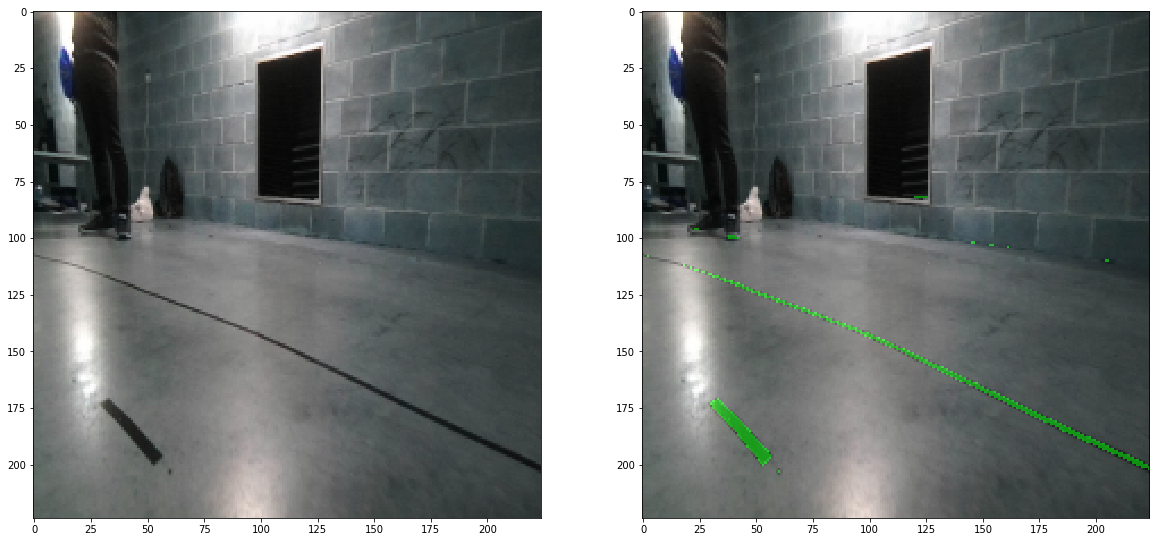

In [214]:
index=np.random.randint(tests.shape[0])
index = 15
test = tests[index:index+1]
print(test.shape)

# %time test_label = tiramisu.model.predict(test)
%time prediction = tiramisu.predict_one(test[0])
# print(test_label)
# plot_images(test[0], test_label[0])
plot_images(test[0], prediction)

prediction[prediction >= 0.9] = 1
prediction[prediction <= 0.9] = 0

In [1]:
index=np.random.randint(tests.shape[0])
test = tests[index:index+1]
# test = images.copy()

%time prediction = tiramisu.predict_one(test[0])

from scipy.ndimage.measurements import label
# left = minus, right = plus
def get_steering_from_prediction(prediction, original=None):
    prediction[prediction >= 0.9] = 1
    prediction[prediction <= 0.9] = 0
    labels = label(prediction[:,:,0])
    positive_gradients = [] 
    negative_gradients = []
    
    img = None
    if original is not None:
        img = original.copy()

    for object_no in range(1, labels[1]+1):
        # Find pixels with each  label value
        nonzero = (labels[0] == object_no).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if ((np.max(nonzeroy)-np.min(nonzeroy)>10) & (np.max(nonzerox)-np.min(nonzerox)>10)):
            fit = np.polyfit(nonzeroy, nonzerox, 1)
            # gradients are reversed because the image starts with 0 at the top
            if(fit[0] > 0):
                negative_gradients.append(-fit[0])
            else:
                positive_gradients.append(-fit[0])
            if original is not None:
                bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 1)
    
    # add small value to avoid nan
    if len(positive_gradients) == 0:
        positive_gradients.append(1e-3)
    if len(negative_gradients) == 0:
        negative_gradients.append(1e-3)

    if original is not None:
        print(positive_gradients, negative_gradients)
        print(np.mean(positive_gradients), np.mean(negative_gradients))
        figure = plt.figure(figsize=(20,12))
        plt.imshow(img, cmap='gray')
    return np.mean(positive_gradients) + np.mean(negative_gradients)

%time steering = get_steering_from_prediction(prediction)
print(steering)

NameError: name 'np' is not defined

In [127]:
def plot_two(img1, img2):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.subplot(1, 2, 2)
    plt.imshow(img2)

(224, 224)
(90, 112)
[[  2.85042963e-02  -9.89594810e-01]
 [ -9.89594810e-01   4.04920054e+01]]
[[  3.13582804e-05  -9.55270894e-04]
 [ -9.55270894e-04   3.66471628e-02]]
left fit:  [ -0.13673393  66.98255268]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66 103 104 105 106 107
 108 109 110 111]
mean:  41.7631578947  std:  30.0363238084
right fit:  [  0.91186329  61.24639424]
[ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
mean:  85.5  std:  15.0083310198


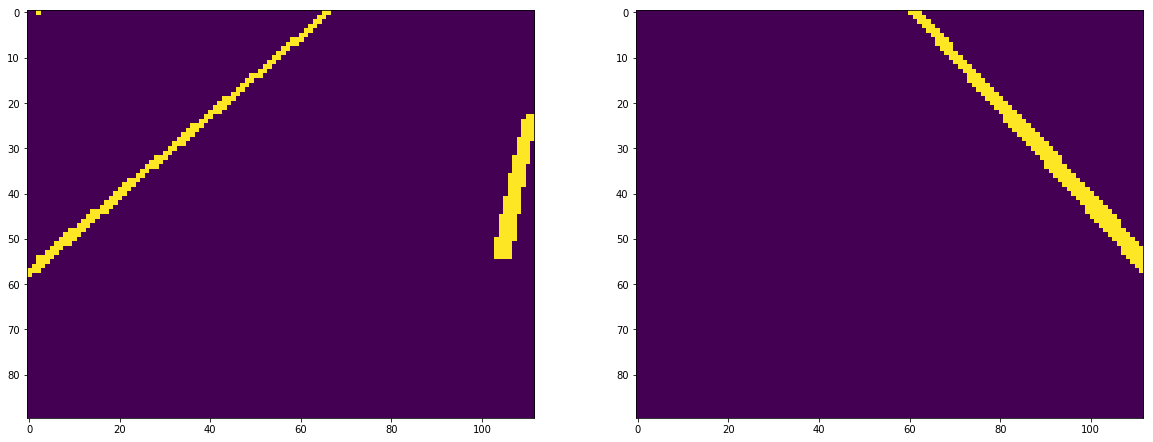

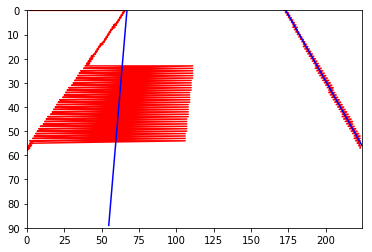

In [175]:
test_label = np.squeeze(test_label)
print(test_label.shape)

def get_line_fit(points):
    y, x = np.nonzero(points)
    image_height = points.shape[0]
    y_axis = np.linspace(0, image_height-1, num=image_height)
    fit, cov = np.polyfit(y, x, 1, cov=True)
#     line_fitx = -fit[0]*y_axis**2 - fit[1]*y_axis - fit[2]
    print(cov)
    line_fitx = fit[0]*y_axis + fit[1]
    return line_fitx




left = test_label[int(6*test_label.shape[0]/10):,:int(test_label.shape[1]/2)]
right = test_label[int(6*test_label.shape[0]/10):,int(test_label.shape[1]/2):]
print(left.shape)
plot_two(left, right)


y, x = np.nonzero(left)
left_fitx = get_line_fit(left)

image_height = left.shape[0]
y_axis = np.linspace(0, image_height-1, num=image_height)
# print(left_fit)
plt.figure()
plt.plot(x, y, color='red')
plt.plot(left_fitx, y_axis, color='blue')
plt.xlim(0, left.shape[1]*2)
plt.ylim(0, image_height)

y, x = np.nonzero(right)
x = x + 112
right_fitx = get_line_fit(right)
right_fitx = right_fitx + 112
plt.plot(x, y, color='red')
plt.plot(right_fitx, y_axis, color='blue')
plt.gca().invert_yaxis() # to visualize as we do the images


yl, xl = np.nonzero(left)
# fig, ax = plt.subplots()
# line1, = ax.plot(np.linspace(0, 112, 112), x, '-', linewidth=2)
# plt.show()
fit_l = np.polyfit(yl, xl, 1)
# line_fitx = fit[0]*y_axis**2 + fit[1]*y_axis + fit[2]
print("left fit: ", fit_l)
xl = np.unique(xl)
print(xl)
print("mean: ", xl.mean(), " std: ", xl.std())

yr, xr = np.nonzero(right)
fit_r = np.polyfit(yr, xr, 1)
print("right fit: ", fit_r)
xr = np.unique(xr)
print(xr)
print("mean: ", xr.mean(), " std: ", xr.std())

In [ ]:
window = np.ones(224)

#take rows from 60% up and left side
l_sum = np.sum(test_label[int(6*test_label.shape[0]/10):,:int(test_label.shape[1]/2)], axis=0)
l_center = np.argmax(np.convolve(window,l_sum))-224/2
# r_sum = np.sum(warped[int(6*warped.shape[0]/10):,int(warped.shape[1]/2):], axis=0)
# r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
